In [1]:
import os
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive
print("You're on Google Colab")
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
    os.chdir('My Drive/--DATA SCIENCE/PROJET4')
!pip install -r requirements_modelling.txt

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


In [2]:
from P4_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import io
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')
import dill
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce
import scipy.stats as st
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [4]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

In [5]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [6]:
path_csv = 'DATA/Cleaned_data.csv' 
# Importing database from my Drive
print("2. Try to import in notebook from myDrive...")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [7]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [8]:
speak('importations done')

In [9]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

In [10]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]
df_X.shape, df_y.shape

((1651, 25), (1651, 2))

# FILTRAGE DES OUTLIERS

### Zscore

total nb of observations:  (1651, 13)


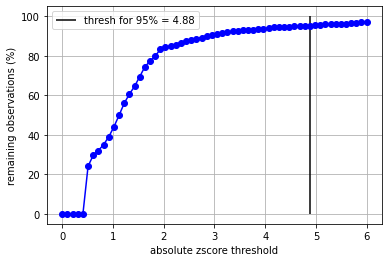

In [155]:
# ZSCORE PARTIE QUANTITATIVE
df_X_num = df_X.select_dtypes(include=[np.number]).copy('deep')
print("total nb of observations: ", df_X_num.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
tab_shape=[]
thresholds = np.linspace(0,6,60)
for t in thresholds:
    zsf = ZscoreSampleFilter(thresh=t)
    df_ = zsf.fit_transform(df_X_num)
    tab_shape.append(df_.shape[0]*100/df_X_num.shape[0])
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = thresholds)
thresh = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(thresh, 0, 100, label='thresh for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, thresh))
plt.xlabel("absolute zscore threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

### LocalOutlierFactor

In [182]:
# Encoding categorical features
ct = CustTransformer(strat_binary='ord',
                     strat_low_card='ord',
                     strat_high_card='ord',
                     strat_quant='none')
df_X_enc = ct.fit_transform_df(df_X)

total nb of observations:  (1651, 25)


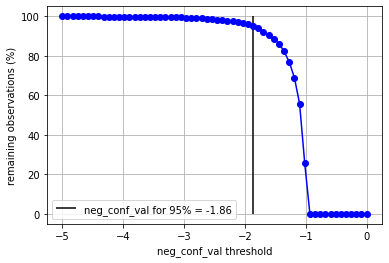

In [156]:
print("total nb of observations: ", df_X_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
neg_conf_vals = np.linspace(-5,0,60)
tab_shape=[]
for ncv in neg_conf_vals:
    loff = LOFSampleFilter(neg_conf_val=ncv, n_neighbors=20)
    df_ = loff.fit_transform(df_X_enc)
    prop = df_.shape[0]*100/df_X_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = neg_conf_vals)
neg_conf_val = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(neg_conf_val, 0, 100, label='neg_conf_val for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, neg_conf_val))
plt.xlabel("neg_conf_val threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

### IsolationForest

total nb of observations:  (1651, 25)


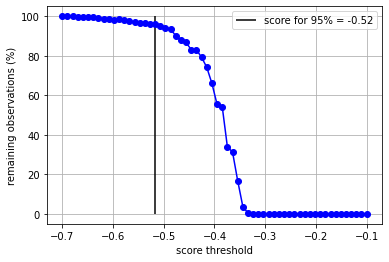

In [157]:
# ISOLATION FOREST (après encodage des valeurs catégorielles)

print("total nb of observations: ", df_X_enc.shape)
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
contamination_level_pct = 5
score_samples_list = np.linspace(-0.1,-0.7,60)
tab_shape=[]
for sc in score_samples_list:
    isolf = IsolForestSampleFilter(score_samples=sc, n_estimators=100)
    df_ = isolf.fit_transform(df_X_enc)
    prop = df_.shape[0]*100/df_X_enc.shape[0]
    tab_shape.append(prop)
# Affichage du nombre de lignes restantes après filtrage selon le seuil
res = pd.DataFrame(tab_shape, index = score_samples_list)
score = res.loc[res.values>100-contamination_level_pct].idxmin()[0]
plt.plot(res, '-ob')
plt.vlines(score, 0, 100, label='score for {:.0f}% = {:.2f}'\
           .format(100-contamination_level_pct, score))
plt.xlabel("score threshold")
plt.ylabel("remaining observations (%)")
plt.legend()
plt.grid()

Let's now put the detection results by the three algorithms for the same contamination fraction in a dataframe.

In [202]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

df_outliers = pd.DataFrame(index=df_X.index)

# zscore outlier detection column
df_outliers['ZscoreOutlier'] = np.nan
zsf = ZscoreSampleFilter(thresh=thresh) # threshold determined above (contamination 5%)
df_ = zsf.fit_transform(df_X_num)
df_outliers.loc[df_.index, 'ZscoreOutlier'] = False
df_outliers['ZscoreOutlier'] = df_outliers['ZscoreOutlier']\
                              .where(df_outliers['ZscoreOutlier']==False, True)

# local outlier factor outlier dectection column
df_outliers['LOFOutlier'] = np.nan
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
res = lof.fit_predict(df_X_enc)
df_outliers['LOFOutlier'] = pd.Series(res,
                                      index = df_outliers.index).map({-1: True,
                                                                      1: False})

# isolation forest outlier detection column
df_outliers['IsolFOutlier'] = np.nan
isolf = IsolationForest(n_estimators=100, contamination=0.05)
res = isolf.fit_predict(df_X_enc)
df_outliers['IsolFOutlier'] = pd.Series(res,
                                      index = df_outliers.index).map({-1: True,
                                                                      1: False})


In [205]:
# Nb of outliers depending on the detection technique
df_outliers.groupby(['ZscoreOutlier',
                     'LOFOutlier',
                     'IsolFOutlier']).size().reset_index()

,ZscoreOutlier,LOFOutlier,IsolFOutlier,0
0,False,False,False,1478
1,False,False,True,19
2,False,True,False,72
3,True,False,False,14
4,True,False,True,57
5,True,True,False,4
6,True,True,True,7


The 3 outlier detection techniques has led to very different selection of outliers.
On 83 outliers detected (5% of 1651) by each algoriths, only:
- 57+7=64 are both considered as outliers by Zscore and IsolationForest
- None are both considered as outliers by LocalOulierFactor and IsolationForest
- 4+7=11 is considered as outliers by Zscore and LocalOutlierFactor
- 7 are considerd as outliers by the three algorithms at the same time.

We should expect different results on out models while filtering with each method.

# TRAIN and TEST SPLIT (WITH OUTLIER FILTERING)

In [226]:
group_col = 'PrimaryPropertyType'

def tr_te_split_with_outliers_filter(dfX, dfy, df_outliers,
                                         strategy, group_col):

    # strategies : 'ZscoreOutlier', 'LOFOutlier', 'IsolFOutlier', None
    if strategy is not None:
        mask = (df_outliers[strategy]==False)
        df_X_mod, df_y_mod = dfX[mask], dfy[mask]
    else:
        df_X_mod, df_y_mod = dfX, dfy

    X_tr, X_te, y_tr, y_te = train_test_split(df_X_mod, df_y_mod,
                                            train_size=0.8, shuffle=True,
                                            stratify=df_X_mod[group_col],
                                            random_state=14)
    return X_tr, X_te, y_tr, y_te

In [232]:
X_tr, X_te, y_tr, y_te = \
     tr_te_split_with_outliers_filter(df_X, df_y, df_outliers,
                                      'IsolFOutlier', group_col)

# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((1254, 25), (1254, 2), (314, 25), (314, 2))

In [126]:
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_SEU_pimp = load_pickle("P4_pimp_SEU.pkl")

--No pickle yet as  P4_models_SEU.pkl
--No pickle yet as  P4_lcurves_SEU.pkl
--No pickle yet as  P4_pimp_SEU.pkl


In [128]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves
dict_pimp = dict_SEU_pimp

In [122]:
models_file_name = 'P4_models_SEU_2.pkl'
l_curves_file_name = 'P4_l_curves_SEU_2.pkl'
perm_imp_file_name = 'P4_models_SEU_2.pkl'

In [123]:
df_res = pd.DataFrame(dtype = 'object')

In [124]:
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

# MODELS

In [147]:
reg = KNeighborsRegressor()
name_reg = 'KNN_woz_nn_enc_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': [ 'ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [3,], # 1,2,3,4,5,7,9,11,15,17
            name_reg+'__p': [2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

file_name = 'truc.pkl'
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])

dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)
cv_search = skf
search_strat = 'grid'
n_iter=None

scv = GridSearchCV(pipe, param_grid = param_grid,
                           cv=cv_search, 
                           scoring=dict_scv_params['scv_scores'], 
                           refit=dict_scv_params['refit'],
                           return_train_score=True,
                           verbose=1)
scv.fit(X=dict_scv_params['X'],y=dict_scv_params['y'])


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


GridSearchCV(cv=[(array([  10,   64,  153, ..., 1252, 1253, 1254]),
                  array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100...
                         'preproc__cust_trans__strat_quant': ['stand']},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
             scoring={'mae': make_scorer(calc_mae, greater_is_better=False),
                      'mpse': make_scorer(calc_mpse, greater_is_better=False),
                      'pred_rate_10': make_scorer(calc_pr

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_woz_nn_enc_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe', 'bin', 'ord',], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ord', 'bin', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [3,4,5,7,9,11,15,17], # 1,2,3,4,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
-----...model dumped'''

-----Model not existing - computing...
Grid
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  8.4min finished


-----...model dumped


'-----Model not existing - computing...\nGrid\nFitting 5 folds for each of 20 candidates, totalling 100 fits\n[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished\n-----...model dumped'